### 1) Preprocessing

In [1]:
import os
import shutil
import shap
import numpy as np
import tensorflow as tf
from keras.utils import image_dataset_from_directory, load_img
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import cv2
from torchvision.transforms.functional import normalize

 1.1) Loading an image dataset from the 'flowers' directory using the image_dataset_from_directory function. It resizes the images to 128x128 pixels and groups them into batches of 32 images each for easier processing.

In [2]:
data = image_dataset_from_directory(
    'flowers',
    image_size=(128, 128),
    batch_size=32 
)

Found 1517 files belonging to 2 classes.


1.2) Labeling the images into arrays and appends them to the respective listsand normalizing the data, and since the pixel values of the images are normalized by dividing by 255.0, scaling the values to the range [0, 1].

In [3]:
images, labels = [], []
for image, label in data:
    images.append(image.numpy())
    labels.append(label.numpy())
images, labels = np.concatenate(images), np.concatenate(labels)
images /= 255.0

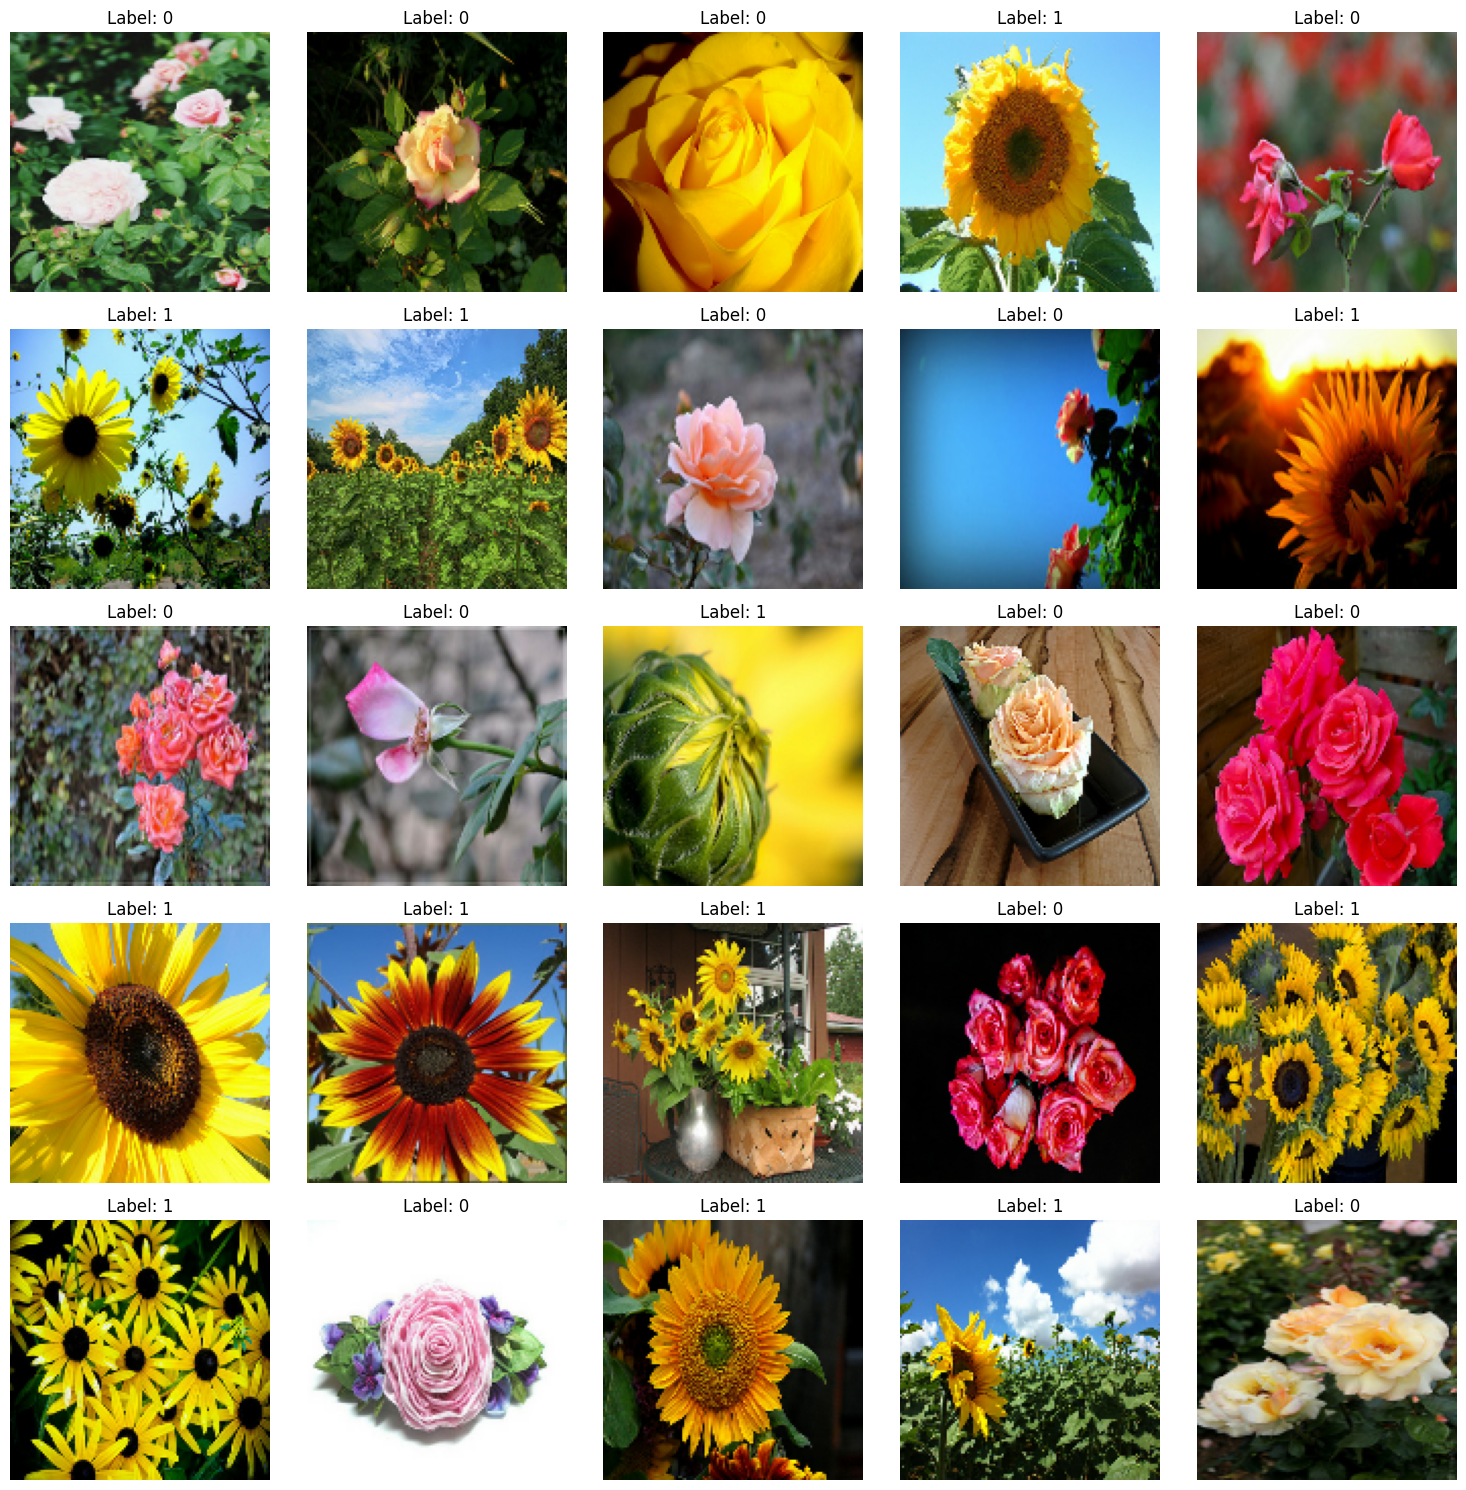

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25):
    axes[i].imshow(images[i])
    axes[i].axis('off') 
    axes[i].set_title(f"Label: {labels[i]}")

plt.tight_layout()

### 2) Buidling the model

2.1) Concatenating image and label arrays into training and testing sets using the train_test_split function. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, shuffle=True, random_state=11, stratify=labels)

2.2) Training a convolutional neural network (CNN) for image classification.

**Model Architecture:**
- <u>Input Layer</u>: The model takes input images of shape (128, 128, 3), where 3 represents the RGB color channels.
- <u>Convolutional Layers:</u>
Conv2D layers apply convolution operations, using 32 filters in the first layer and 16 in the second, with a kernel size of 3x3 and ReLU activation.
MaxPooling2D layers downsample the feature maps by a factor of 2.
- <u>Flatten Layer:</u> The output from the convolutional layers is flattened into a 1D vector.
- Dense Layer: A fully connected layer with 3 output units (for 3 classes).
- <u>Softmax Activation:</u>The output layer uses softmax to produce class probabilities.

The model is compiled with the Adam optimizer, and converts the labels to one-hot encoded format for multi-class classification.

The training process uses a batch size of 32, runs for 10 epochs, and uses 15% of the training data for validation.

In [6]:
inputs = Input(shape=(128, 128, 3), name="Input")
x = Conv2D(32, 3, activation="relu", padding='same', name='Conv1')(inputs)
x = MaxPooling2D(2, name='Pool1')(x)
x = Conv2D(16, 3, activation="relu", padding='same', name='Conv2')(x)
x = MaxPooling2D(2, name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
x = Dense(2, name='FC')(x)
outputs = Activation("softmax", name='Softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()

hist = model.fit(
    X_train,
    to_categorical(y_train, 2),
    batch_size=32,
    epochs=10,
    validation_split=0.15,
    shuffle='on'
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Vectorize (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC (Dense)                      │ (None, 2)              │        32,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,290 (149.57 KB)

 Trainable params: 38,290 (149.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - acc: 0.5916 - loss: 0.6548 - val_acc: 0.8304 - val_loss: 0.3768
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.8630 - loss: 0.3102 - val_acc: 0.8889 - val_loss: 0.2743
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.9011 - loss: 0.2553 - val_acc: 0.8889 - val_loss: 0.2615
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.9239 - loss: 0.2092 - val_acc: 0.8655 - val_loss: 0.3299
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.9220 - loss: 0.2195 - val_acc: 0.8129 - val_loss: 0.4145
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.9261 - loss: 0.2170 - val_acc: 0.8947 - val_loss: 0.2411
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - acc: 0.9422 - loss: 0.1680 - val_acc: 0.8830 - val_loss: 0.2668
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.9760 - loss: 0.1140 - val_acc: 0.8480 - val_loss: 0.3481
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - acc: 0.9707

2.3) Evaluating the performance of the trained CNN model on the test

In [7]:
y_hat=model.predict(X_test)
print('Acc=',np.sum(y_hat.argmax(1)==y_test)/y_test.shape[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Acc= 0.9


### 3) Shap

3.1)  SHAP (SHapley Additive exPlanations) to explain the model's predictions for a specific test image from the dataset. 

- Taking an input x, makes a copy of it, and passes it to the trained model to get predictions.
- Creating a SHAP masker that will generate blurred versions of the input images.

  0%|          | 0/4998 [00:00<?, ?it/s]

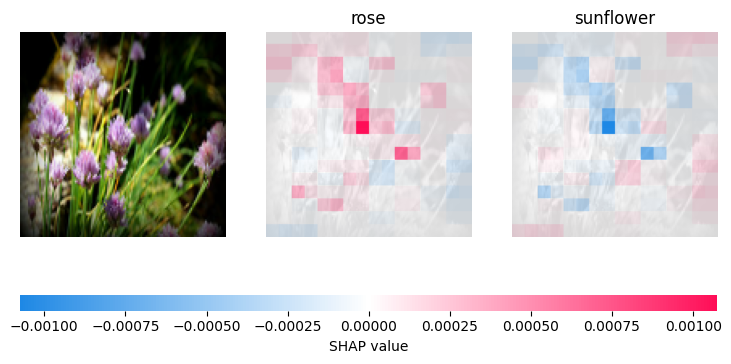

In [8]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(128,128)", X_test[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))
ind=[310]
shap_values_ = explainer( X_test[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=['rose','sunflower'])

In [9]:
import os
import torch
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from torchvision import models, transforms
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# Custom GradCAM class
import GradCam

In [10]:
# Directory structure
data_dir = 'flowers'
classes = ['rose', 'sunflower']

# Transformation for ResNet input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
# Load ResNet model for feature extraction
original_resnet_model = models.resnet50(pretrained=True)
resnet_model = torch.nn.Sequential(*list(original_resnet_model.children())[:-1])

c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Function to extract embeddings
def get_embedding(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        embedding = model(image).squeeze().numpy()
    return embedding

In [13]:
# Lists to store embeddings and labels
embeddings = []
labels = []
file_paths = []

# Extract embeddings for all images
for label_idx, label_name in enumerate(classes):
    folder_path = os.path.join(data_dir, label_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            embedding = get_embedding(img_path, resnet_model, transform)
            embeddings.append(embedding)
            labels.append(label_idx)
            file_paths.append(img_path)
        except Exception as e:
            print(f"Could not process image {img_path}: {e}")

In [14]:
# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

In [15]:
# Split the embeddings and labels for training and validation
X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(
    embeddings, labels, file_paths, test_size=0.2, random_state=42, stratify=labels
)

In [16]:
# Train a Random Forest classifier on embeddings
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Select prototypes for each class using KMeans clustering
n_prototypes = 25
selected_prototypes = {label: [] for label in classes}

for label_idx, label_name in enumerate(classes):
    class_embeddings = embeddings[labels == label_idx]
    class_paths = np.array(file_paths)[labels == label_idx]

    kmeans = KMeans(n_clusters=n_prototypes, random_state=42)
    kmeans.fit(class_embeddings)

    for cluster_center in kmeans.cluster_centers_:
        distances = np.linalg.norm(class_embeddings - cluster_center, axis=1)
        closest_idx = np.argmin(distances)
        selected_prototypes[label_name].append(class_paths[closest_idx])

c:\Users\patri\Python\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\patri\Python\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [26]:
probs = rf_clf.predict_proba(X_val)

# Calculate maximum probabilities for each sample
max_probs = np.max(probs, axis=1)  # Get the highest probability for each sample

# Define the threshold range around 50% (e.g., 45% to 55%)
lower_bound = 0.45
upper_bound = 0.55

# Get indices of samples with probabilities close to 50%
indices_near_50 = np.where((max_probs >= lower_bound) & (max_probs <= upper_bound))[0]

print("Indices of images with probabilities around 50%:", indices_near_50)

# Optionally, you can print additional info about these samples
for idx in indices_near_50:
    print(f"Index: {idx}, Probability: {max_probs[idx]:.2f}, Label: {y_val[idx]}, Predicted: {rf_clf.predict([X_val[idx]])[0]}")

Indices of images with probabilities around 50%: [  2  14  17  32  38  44  58  61  62  67  68  69  71  81  84  85  89  92
 102 103 109 113 114 117 118 123 138 146 153 154 159 163 164 184 185 189
 196 199 206 207 210 214 228 229 230 234 243 246 247 250 254 257 258 276
 277 280 282 291 292 294 301]
Index: 2, Probability: 0.55, Label: 1, Predicted: 0
Index: 14, Probability: 0.51, Label: 1, Predicted: 0
Index: 17, Probability: 0.52, Label: 1, Predicted: 1
Index: 32, Probability: 0.55, Label: 0, Predicted: 0
Index: 38, Probability: 0.51, Label: 1, Predicted: 0
Index: 44, Probability: 0.54, Label: 0, Predicted: 1
Index: 58, Probability: 0.55, Label: 1, Predicted: 0
Index: 61, Probability: 0.55, Label: 1, Predicted: 0
Index: 62, Probability: 0.55, Label: 0, Predicted: 0
Index: 67, Probability: 0.50, Label: 1, Predicted: 0
Index: 68, Probability: 0.54, Label: 1, Predicted: 1
Index: 69, Probability: 0.51, Label: 0, Predicted: 0
Index: 71, Probability: 0.55, Label: 1, Predicted: 0
Index: 81, Pro

# HERE COMES FOR THE FORMS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model Prediction: sunflower


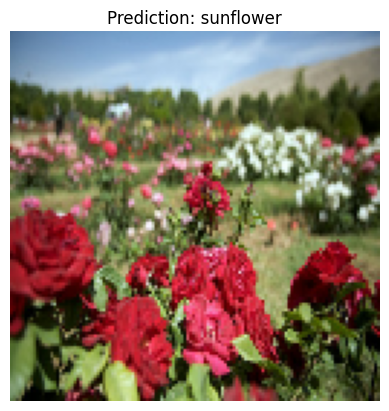

In [27]:
from tensorflow.keras.preprocessing.image import img_to_array

# Select and preprocess the same image for SHAP and Prototype
selected_image_index = 67 # example index, adjust as needed
selected_image = X_test[selected_image_index]

# Model prediction
prediction = model.predict(np.expand_dims(selected_image, axis=0))
predicted_class = np.argmax(prediction)
print(f"Model Prediction: {'rose' if predicted_class == 0 else 'sunflower'}")
plt.imshow(selected_image)
plt.title(f"Prediction: {'rose' if predicted_class == 0 else 'sunflower'}")
plt.axis('off')
plt.show()


  0%|          | 0/4998 [00:00<?, ?it/s]

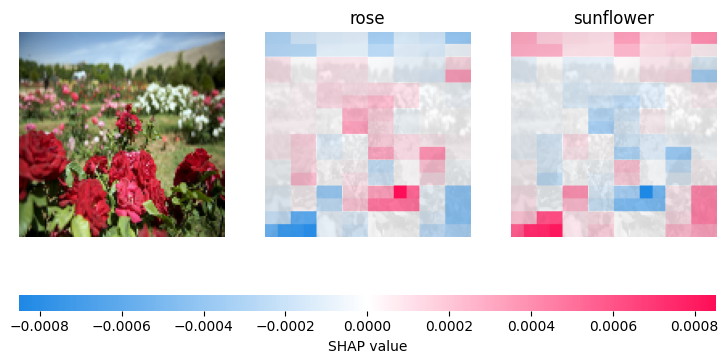

In [28]:
# Generate SHAP explanation
shap_values = explainer(np.expand_dims(selected_image, axis=0), max_evals=5000, batch_size=50)
shap.image_plot(shap_values, labels=['rose', 'sunflower'])


c:\Users\patri\Python\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


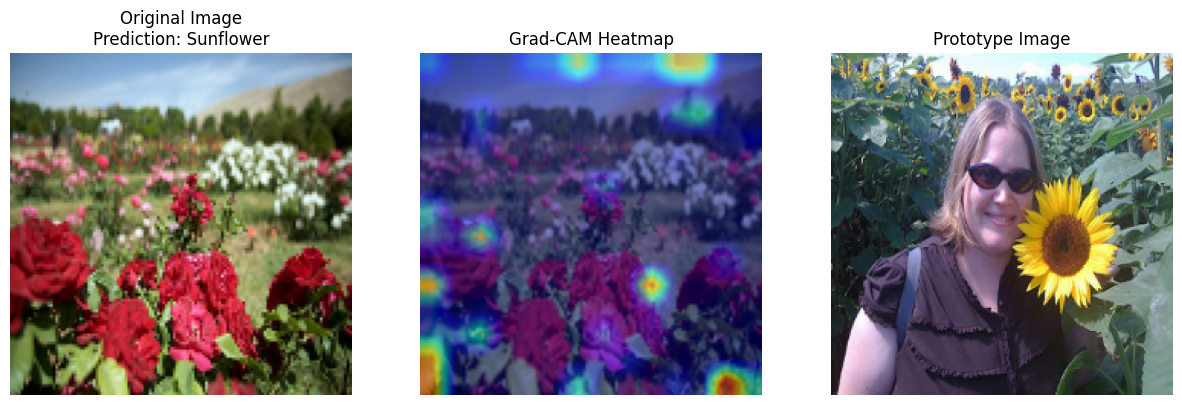

In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# Choose the label name based on the model's predicted class from Question 1
class_name = 'rose' if predicted_class == 0 else 'sunflower'

# Step 1: Find the Closest Prototype
# Use the first prototype for simplicity; adjust this if you'd like to explore other prototypes.
prototype_path = selected_prototypes[class_name][0]  # Get the path of the closest prototype
prototype_image = cv2.imread(prototype_path)
prototype_image = cv2.resize(prototype_image, (224, 224))  # Resize prototype to match the display size

# Step 2: Apply Grad-CAM on the Selected Image
# Preprocess the original image to match the model input
image_tensor = transform(Image.fromarray((selected_image * 255).astype(np.uint8)).convert('RGB')).unsqueeze(0)
cam = grad_cam(image_tensor, predicted_class)  # Generate the Grad-CAM heatmap

# Step 3: Overlay Grad-CAM Heatmap onto the Original Image
# Resize the original image to 224x224 to match the Grad-CAM output dimensions
original_image_resized = cv2.resize((selected_image * 255).astype(np.uint8), (224, 224))
original_image_bgr = cv2.cvtColor(original_image_resized, cv2.COLOR_RGB2BGR)


# Apply the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original_image_bgr, 0.5, heatmap, 0.5, 0)  # Combine heatmap with the original image


# Step 4: Display the Original Image with Prediction, Prototype, and Grad-CAM Heatmap
plt.figure(figsize=(15, 5))

# Display the Original Image with Prediction Label
plt.subplot(1, 3, 1)
plt.imshow(selected_image)
plt.title(f"Original Image\nPrediction: {class_name.capitalize()}")
plt.axis('off')

# Display the Grad-CAM Heatmap Overlay
plt.subplot(1, 3, 2)
plt.imshow(overlay[..., ::-1])  # Convert BGR to RGB for display
plt.title("Grad-CAM Heatmap")
plt.axis('off')

# Display the Prototype Image
plt.subplot(1, 3, 3)
plt.imshow(prototype_image[..., ::-1])  # Convert BGR to RGB for display
plt.title("Prototype Image")
plt.axis('off')

plt.show()


indxes used: 310, 11, 176, 364